In [1]:
import shutil, os, warnings, re, datetime, multiprocessing
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import gensim
import matplotlib.cm as cm
import tensorflow as tf
import _pickle as pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec, Word2Vec
from itertools import chain, combinations
from sklearn.metrics.pairwise import euclidean_distances
from collections import namedtuple, Counter
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
warnings.filterwarnings(action='default')

In [2]:
df = pd.read_csv('./Datasets/total_table_MainTotal.csv', dtype='str', encoding='utf-8')
ConstType = pd.read_csv('./Datasets/ConstructionType.csv',encoding='utf-8',dtype='str')#공사유형
ConstType  = ConstType.rename(columns={"WORKNM":"ConstructionType"})
ConstType = ConstType[["ConstructionType","WORKID"]].drop_duplicates()
df = pd.merge(df, ConstType, on="ConstructionType", how="left").drop(
    ["ConstructionType"],axis=1).rename(columns={"WORKID":"ConstructionType"})

df = df[df.Option_rep=="N"].dropna()
df['OrderTime'] =  pd.to_datetime(df['OrderTime'])
df['OrderDate'] =  df['OrderTime'].dt.date
df = df.drop(['SubOrderNum','GroupID','OrderAccount','ShipDate','DeliDate',
'RequestDeliDate','SupplyID','Supplynm','CompanyID','Companynm','Option_rep',
'Constructionnm','Bpnm','Region','Productnm','ProductSize','ProductType1',
'LCategory','MCategory','SCategory','OrderAmt','UnitPrice'], axis =1)
df = df.rename(columns={'BpRegion':'Region'})
df = df.drop_duplicates(keep='first')
df1 = df.drop(['OrderNum'],axis = 1)
df1 = df1.groupby(['OrderDate','BpID','Region','ConstructionType','BpType','BpClass']).agg({
    "ProductCode":list,"OrderTime":"max"}).reset_index()
df2 = df1.sort_values(['BpID','OrderTime']).reset_index(drop = True)
df2.ConstructionType = "c"+df2['ConstructionType']
df2.Region = "r"+df2['Region']

print(df2.shape)

(103782, 8)


In [4]:
d2v_size = 15
model_loc = "./Trained_models/Models_WnD/sub_recommendation_pvdbow.model"
epoch = 100

data = df2[["ProductCode","BpID","ConstructionType","Region"]]
data1 = [(row['ProductCode'], row[["BpID","ConstructionType","Region"]].tolist()) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
tagged_data2 = [data2(d, c) for d, c in data1]

model = Doc2Vec(
    dm = 0,  # 0 : PV-DBOW
    dbow_words = 0,
    window = 8, vector_size = d2v_size, alpha = 0.025, min_alpha = 0.025, seed = 0, sample= 1e-5, min_count=3, 
    workers=multiprocessing.cpu_count(), hs = 0, negative = 10)
model.build_vocab(tagged_data2)
print('Doc2Vec training step--started')
model.train(documents  = tagged_data2, total_examples = data.shape[0], epochs = epoch)
model.save(model_loc)
print('Doc2Vec training step--done. check--',model_loc)

Doc2Vec training step--started
Doc2Vec training step--done. check-- ./Trained_models/Models_WnD/sub_recommendation_pvdbow.model


In [108]:
model=Doc2Vec.load("./Trained_models/Models_WnD/sub_recommendation_pvdbow.model")
# Bp_docvec = model.docvecs["304576"]
# Const_docvec = model.docvecs["c7"]
# Region_docvec = model.docvecs["r10"]
# similar_words = model.most_similar(positive=[Bp_docvec, Const_docvec, Region_docvec])
# similar_words
# model.similar_by_word(word='10000005910')

# aa = model.infer_vector(['304576'])
# model.similar_by_vector(aa)
# model.wv.most_similar(['10000019381'])
# model.wv.most_similar(['10000005910'])
# model.wv.most_similar(['10000019381','10000005910'])

# 자재정보
Items = pd.read_csv('./Datasets/total_table_MainTotal.csv', dtype='str', encoding='utf-8')
Items = Items[Items.ProductType1.isin(['10','20'])]
Items = Items[["ProductCode","Productnm","ProductType1","ProductSize"]].drop_duplicates().reset_index(drop=True)
conditions = [(Items['ProductType1']=='10'),(Items['ProductType1']=='20')];choices = ['일반','지정']
Items['ProductType'] = np.select(conditions,choices,default='none')
Items = Items.drop(["ProductType1"],axis=1).fillna("")

In [110]:
# Item only
# 전부다 하기 힘드니 가장 많은 50개의 자재에 대해서만 top 10를 뽑아보자.
itemcnt = Counter(df.ProductCode)
itemcntlist = np.array(itemcnt.most_common(n=50))[:,0]

est_df = pd.DataFrame()
for ii in range(len(itemcntlist)):
    tmpdf = pd.DataFrame(model.similar_by_word(word=itemcntlist[ii], topn=10), columns=["ms_item","score"])
    tmpdf['ProductCode'] = itemcntlist[ii]
    est_df = pd.concat([est_df, tmpdf], axis=0)
    
# est_df
ms_Items = Items.copy()
ms_Items.columns=["ms_item","ms_Productnm","ms_ProductSize","ms_ProductType"]
result = pd.merge(pd.merge(est_df, ms_Items, on='ms_item', how='left'), Items, on='ProductCode', how='left')
result = result[['ms_item','ms_Productnm','ms_ProductSize','ms_ProductType',
                 'ProductCode','Productnm','ProductSize','ProductType','score']]
result.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [111]:
# Item with Consttype

(500, 9)

In [71]:
14000*14000

196000000

In [78]:
df = pd.read_csv('./Datasets/total_table_MainTotal.csv', dtype='str', encoding='utf-8')
df['OrderTime'] =  pd.to_datetime(df['OrderTime'])
df['OrderDate'] =  df['OrderTime'].dt.date
df = df.drop(['SubOrderNum','GroupID','OrderAccount','ShipDate','DeliDate',
'RequestDeliDate','SupplyID','Supplynm','CompanyID','Companynm','Option_rep',
'Constructionnm','Bpnm','Region','ProductSize','LCategory','MCategory','SCategory','OrderAmt','UnitPrice'], axis =1)
df['Product']=df.ProductCode +"/_/"+  df.Productnm +"/_/"+ df.ProductType1
df = df.rename(columns={'BpRegion':'Region'})
df = df.drop_duplicates(keep='first').dropna()

df1 = df.drop(['OrderNum'],axis = 1)
df2 = df1.groupby(['OrderDate','BpID','Region','ConstructionType','BpType','BpClass']).agg({
    "Product":list,"OrderTime":"max"}).reset_index()
df2 = df2.sort_values(['BpID','OrderTime']).reset_index(drop = True)
print(df2.shape)

(107192, 8)


In [79]:
## 전체 데이터에 대한 Word2Vec 모델 생성
word_list = df2.Product.tolist()
word_unique_list= set(chain.from_iterable(word_list))

model = Word2Vec(word_list,size=150,window=8,min_count=2,
                 workers=multiprocessing.cpu_count(),iter=500,
                 sg=1,seed=0,hs=0,negative=10,alpha=0.025,min_alpha=0.025)
model.save("./Trained_models/Models_Doc2Vec/w2v_150.model")

In [47]:
# ## 공사유형별 Word2Vec 모델 생성
# const_list = df2.ConstructionType.unique()

# for num,const in enumerate(const_list):
#     print(num, len(const_list))
#     word_list = df2[df2.ConstructionType==const].Product.tolist()
    
#     model = Word2Vec(word_list,size=150,window=8,min_count=2,
#                  workers=multiprocessing.cpu_count(),iter=100, # 1/5
#                  sg=1,seed=0,hs=0,negative=10,alpha=0.025,min_alpha=0.025)
#     model_loc = "./Trained_models/Models_Doc2Vec/w2v_150_"+const+".model"
#     model.save(model_loc)

In [52]:
model = Word2Vec.load("./Trained_models/Models_Doc2Vec/w2v_150.model")

/usr/local/lib/python3.5/dist-packages/gensim/utils.py:488: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(self, attrib, None)


In [160]:
example = '6900100054/_/칼블럭/_/10'
K = 10
most_similar = model.most_similar(example, topn=len(model.wv.vocab))

most_similar_df = pd.DataFrame([ii[0].split("/_/") for ii in most_similar],columns=['자재ID','자재명','자재유형'])
most_similar_df['점수'] = [ii[1] for ii in most_similar]

In [161]:
most_similar_df.head(K)

,자재ID,자재명,자재유형,점수
0,2800500323,인장클램프,10,0.528361
1,7000100064,일반나사,10,0.511157
2,7000100099,계량기 함체,10,0.507888
3,7000100044,케이블클램프,10,0.496994
4,7000100075,I 볼트_3/8'',10,0.488526
5,7000100045,케이블클램프,10,0.488291
6,7000100017,새들,10,0.484253
7,7000100033,인장클램프,10,0.482965
8,2800600485,계량기(LS),10,0.481095
9,7000100088,스트롱앵커,10,0.479015


In [162]:
most_similar_df.tail(K)

,자재ID,자재명,자재유형,점수
11554,10000060267,HDMI케이블 테스터기,60,-0.082667
11555,10000023229,필터(부직포),10,-0.083643
11556,10000040622,철개,20,-0.084620
11557,10000010366,스텐가로등 조형물,10,-0.089167
11558,10000042496,작업 가방,10,-0.091760
11559,10000018795,매설주의 표지깃발,10,-0.098347
11560,10000024770,연장케이블(N Type),20,-0.098425
11561,10000009346,KCC 공사자재 #2,10,-0.106804
11562,10000009669,ACF 케이블,20,-0.131774
11563,10000018710,안전 조끼,70,-0.157233


In [42]:
# Doc2Vec 임베딩 새로할때 이하 코드를 쓴다.
df = pd.read_csv('./Datasets/df.csv', dtype='str', encoding = 'utf-8')

df1 = df[['BpID','OrderTime','OrderNum','ProductCode','Region','BpType','BpClass','ConstructionType']].drop_duplicates(keep='first')
df1['OrderTime'] = pd.to_datetime(df1['OrderTime'])
df1 = df1.sort_values(['BpID','OrderTime']).reset_index(drop = True)
df2 = df1.groupby(['BpID', 'OrderTime', 'OrderNum', 'Region', 'BpType',
       'BpClass', 'ConstructionType'])['ProductCode'].apply(list).reset_index()

X_data= df2.copy()
공사유형 = pd.read_csv('c:/users/kim85/OneDrive/Project_AgileSoda/원본/추가6차_181005/공사유형.csv', encoding ='utf-8', dtype ='str')
공사유형 = 공사유형[['WORKID','WORKNM']].rename(columns={'WORKID':'ConstructionType'})

X_data1 = pd.merge(X_data, 공사유형, on='ConstructionType', how='left').drop(['ConstructionType'],axis = 1)
X_data1 = X_data1.rename(columns={'WORKNM':'ConstructionType'})

RegionTable = pd.DataFrame({'Region':['99','10','11','12','13','14','16','15','20','30','40','41','50','51','60','70','80','100','200','300'], 
                            'Regionnm':['전국','강남','강북','인천','서울북','서울남','경기남','경기북','경남','경북',
                                        '전북','전남','충북','충남','강원도','제주도','미정','수도권','중부권','서부권']})
colorlist = ['#B0BF1A','#7CB9E8','#72A0C1','#EDEAE0','#F0F8FF','#C46210','#EFDECD','#FFBF00','#9966CC','#F2F3F4',
             '#CD9575','#665D1E','#915C83','#841B2D','#FAEBD7','#008000','#8DB600','#FBCEB1','#00FFFF','#7FFFD4',
             '#D0FF14','#4B5320','#8F9779','#E9D66B','#B2BEB5','#87A96B','#FF9966','#A52A2A','#FDEE00','#568203',
             '#007FFF','#89CFF0','#F4C2C2',]
X_data2 = pd.merge(X_data1, RegionTable, on='Region', how='left').drop(['Region'],axis = 1)
X_data2 = X_data2.rename(columns={'Regionnm':'Region'})

d2v_size = 15
def myDoc2Vec(data, model_loc, trainTF = False):
    if trainTF == True:
        model = Doc2Vec(
            documents=data,dm=1,dbow_words=0,window=8,vector_size=d2v_size, 
            alpha=0.025,min_alpha=0.025,seed=0,sample=1e-5,min_count=3,hs=0,negative=10,
            workers=multiprocessing.cpu_count())
        model.train(
            documents=data,total_examples=model.corpus_count,epochs=500
            ,start_alpha=0.025,end_alpha=0.025)
        model.save(model_loc)
    else:
        model=Doc2Vec.load(model_loc)
    return model

# 공사유형

In [43]:
# 데이터 준비
data = X_data2[['ConstructionType','ProductCode']]
data.columns = ['docID','item']
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
data1 = [(str(row['item']).split(), row['docID']) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
LabeledSentence2 = [LabeledSentence1(d, [c]) for d, c in data1]

# 데이터 불러오기
model_loc = "./Trained_models/Models_Doc2Vec/d2v_ConstructionType_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.DataFrame(model.docvecs.offset2doctag, columns = ['ConstructionType'], dtype='str'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

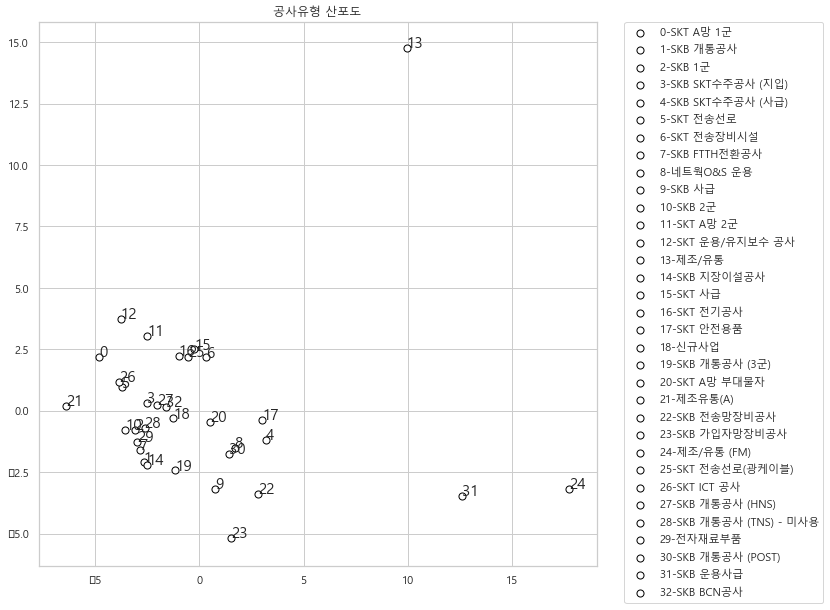

가장 가까운 공사유형 Top10


,distance
SKB 개통공사↔SKB 지장이설공사,0.203444
SKT 전송선로↔SKT ICT 공사,0.253177
SKB FTTH전환공사↔전자재료부품,0.350572
네트웍O&S 운용↔SKB 개통공사 (POST),0.356901
SKT 사급↔SKT 전송선로(광케이블),0.425766
SKB 개통공사 (HNS)↔SKB BCN공사,0.440162
SKB 1군↔SKB 개통공사 (TNS) - 미사용,0.461054
SKT 전기공사↔SKT 전송선로(광케이블),0.461813
SKB 1군↔SKB 2군,0.484715
SKB SKT수주공사 (지입)↔SKB 개통공사 (HNS),0.487925


In [45]:
# 시각화
plt.figure(figsize=(10,10))
plt.title('공사유형 산포도')
for ii in range(len(features)):
    plt.scatter(features.x[ii], features.y[ii], c='w', s = 50, edgecolors='black', label = str(ii)+'-'+features.ConstructionType[ii])
    plt.text(features.x[ii], features.y[ii], features.index[ii], size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("가장 가까운 공사유형 Top10")
pd.DataFrame(pd.Series(eudist2), columns=['distance']).sort_values(by='distance').head(10)

In [46]:
most_similar1 = {ii:np.array(model.most_similar([model.infer_vector(ii)], topn =5))[:,0] for ii in r_names}
most_similar2 = pd.DataFrame(most_similar1).T
for ii in most_similar2.columns:
    most_similar2[ii] = most_similar2[ii].map(lambda x: x.lstrip("['").rstrip("']',"))
print("공사유형별 가까운 상품번호 Top5")
most_similar2

C:\Users\kim85\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
C:\Users\kim85\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


공사유형별 가까운 상품번호 Top3


,0,1,2,3,4
SKB 1군,2800100737,10000025524,10000058782,10000010076,10000025061
SKB 2군,10000025272,7400100005,10000022063,10000010275,10000019258
SKB BCN공사,10000061003,10000057402,2800600545,10000001281,10000057403
SKB FTTH전환공사,10000003251,2800500512,2800100768,10000040492,10000040922
SKB SKT수주공사 (사급),10000041060,2800100826,10000042439,10000022175,7400900094
SKB SKT수주공사 (지입),10000040480,10000001120,10000005891,10000003113,10000003106
SKB 가입자망장비공사,10000039089,10000042574,10000042575,6600200212,10000040564
SKB 개통공사,10000019094,10000024204,10000022047,10000019095,10000024237
SKB 개통공사 (3군),10000009271,2800100787,10000023538,10000042420,10000043281
SKB 개통공사 (HNS),10000021980,10000007599,7400800007,10000007650,10000003375


# 사업장 유형

In [6]:
# 데이터 준비
data = X_data2[['BpType','ProductCode']]
data.columns = ['docID','item']
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
data1 = [(str(row['item']).split(), row['docID']) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
LabeledSentence2 = [LabeledSentence1(d, [c]) for d, c in data1]

# 데이터 불러오기
model_loc = "./Trained_models/Models_Doc2Vec/d2v_BpType_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpType'], dtype='str'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

C:\Users\kim85\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


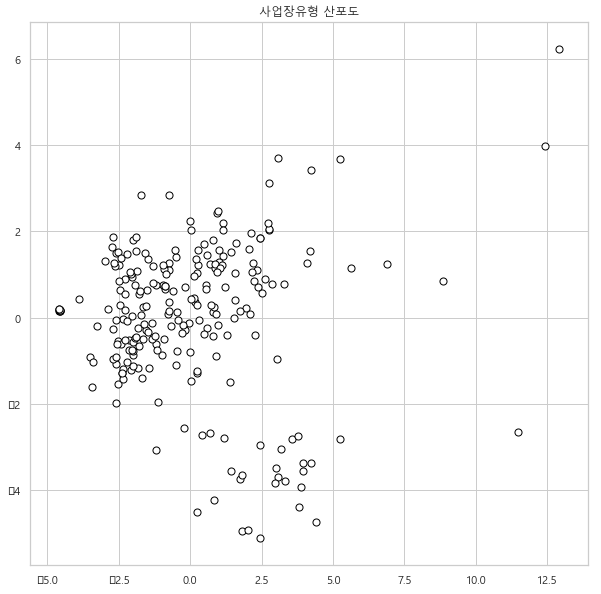

가장 가까운 사업장유형 Top10


,distance
"건설업,제조업,도매및소매업↔IT",0.001381
"정보통신공사, 전기전자통신공사↔플라스틱 제조업",0.004143
"인터넷유지보수, 통신공사↔서비스도소매",0.007812
"도소매, 제조↔일반토목공사",0.008286
플라스틱 제조업↔IT,0.008625
"플라스틱 제조업↔건설업,제조업,도매및소매업",0.010149
"통신망유지보수↔전기,정보통신",0.010631
정전기방지제품↔철구조물,0.011744
제조 외↔IT,0.012040
플라스틱 제조업↔제조 외,0.012119


In [7]:
# 시각화
plt.figure(figsize=(10,10))
plt.title('사업장유형 산포도')
for ii in range(len(features)):
    plt.scatter(features.x[ii], features.y[ii], c='w', s = 50, edgecolors='black', label = str(ii)+'-'+features.BpType[ii])
plt.show()

print("가장 가까운 사업장유형 Top10")
pd.DataFrame(pd.Series(eudist2), columns=['distance']).sort_values(by='distance').head(10)

# 사업장 클래스

In [8]:
# 데이터 준비
data = X_data2[['BpClass','ProductCode']]
data.columns = ['docID','item']
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
data1 = [(str(row['item']).split(), row['docID']) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
LabeledSentence2 = [LabeledSentence1(d, [c]) for d, c in data1]

# 데이터 불러오기
model_loc = "./Trained_models/Models_Doc2Vec/d2v_BpClass_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpClass'], dtype='str'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

C:\Users\kim85\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


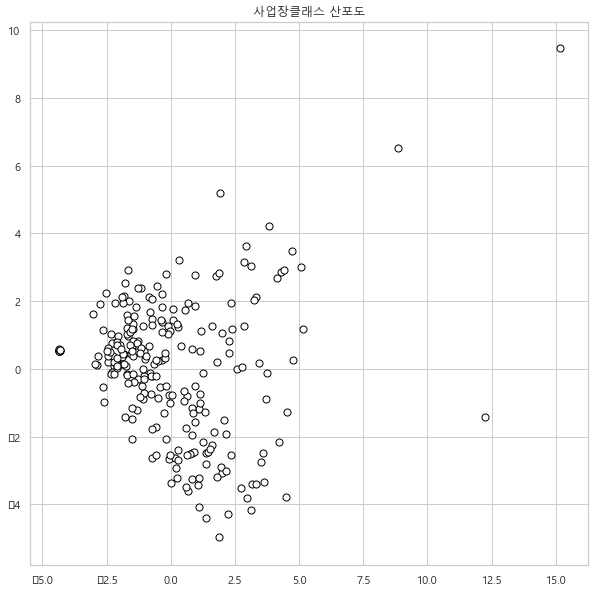

가장 가까운 사업장 클래스 Top10


,distance
통신장비↔케이블절연제 외,0.003383
"제조업, 도매↔IT",0.003906
"제조업, 도매↔전기계장공사외",0.005349
전기계장공사외↔IT,0.008625
"통신장비,소프트웨어개발↔통신장비",0.014286
"통신장비,소프트웨어개발↔케이블절연제 외",0.015317
"제조, 건설업업, 도매, 서비스↔케이블절연제 외",0.015747
"통신장비,소프트웨어개발↔IT",0.017139
"제조, 건설업업, 도매, 서비스↔통신장비",0.018426
"도소매,서비스↔정보통신기자재",0.019466


In [9]:
# 시각화
plt.figure(figsize=(10,10))
plt.title('사업장클래스 산포도')
for ii in range(len(features)):
    plt.scatter(features.x[ii], features.y[ii], c='w', s = 50, edgecolors='black', label = str(ii)+'-'+features.BpClass[ii])
plt.show()

print("가장 가까운 사업장 클래스 Top10")
pd.DataFrame(pd.Series(eudist2), columns=['distance']).sort_values(by='distance').head(10)

# 권역

In [10]:
# 데이터 준비
data = X_data2[['Region','ProductCode']]
data.columns = ['docID','item']
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
data1 = [(str(row['item']).split(), row['docID']) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
LabeledSentence2 = [LabeledSentence1(d, [c]) for d, c in data1]

# 데이터 불러오기
model_loc = "./Trained_models/Models_Doc2Vec/d2v_Region_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.DataFrame(model.docvecs.offset2doctag, columns = ['Region'], dtype='str'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

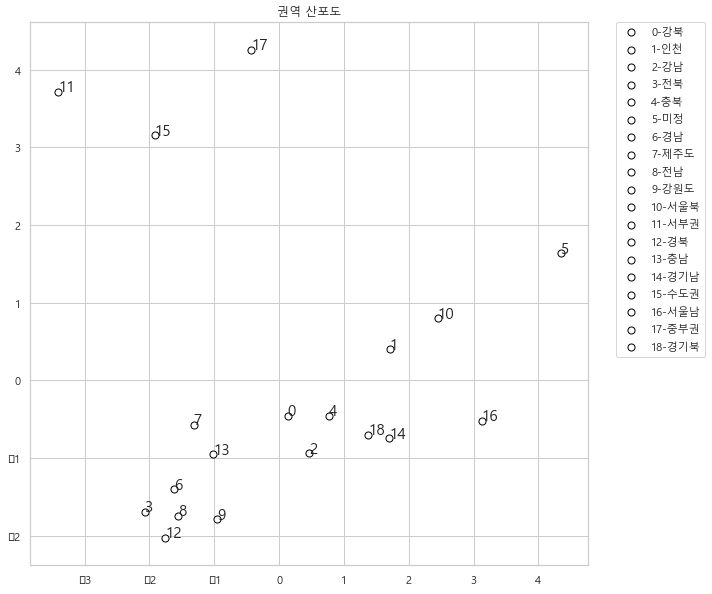

가장 가까운 사업장 클래스 Top10


,distance
경기남↔경기북,0.330559
전남↔경북,0.341695
경남↔전남,0.351299
전북↔경북,0.448448
제주도↔충남,0.485440
전북↔전남,0.506296
전북↔경남,0.533699
강남↔충북,0.568975
강북↔강남,0.580372
전남↔강원도,0.607878


In [11]:
# 시각화
plt.figure(figsize=(10,10))
plt.title('권역 산포도')
for ii in range(len(features)):
    plt.scatter(features.x[ii], features.y[ii], c='w', s = 50, edgecolors='black', label = str(ii)+'-'+features.Region[ii])
    plt.text(features.x[ii], features.y[ii], features.index[ii], size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("가장 가까운 사업장 클래스 Top10")
pd.DataFrame(pd.Series(eudist2), columns=['distance']).sort_values(by='distance').head(10)

# 사업장

In [ ]:
# 데이터 준비
data = X_data2[['BpID','ProductCode']]
data.columns = ['docID','item']
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
data1 = [(str(row['item']).split(), row['docID']) for idx, row in data.iterrows()]
data2 = namedtuple('TaggedDocument', 'words tags')
LabeledSentence2 = [LabeledSentence1(d, [c]) for d, c in data1]

# 데이터 불러오기
model_loc = "./Trained_models/Models_Doc2Vec/d2v_BpID_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.merge(
        pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpID'], dtype='str'), 
        X_data2[['BpID','BpType','BpClass','ConstructionType','Region']].drop_duplicates(keep='first'), 
        on='BpID'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

In [ ]:
# 시각화
plt.figure(figsize=(15,15))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.2, right=0.99)

plt.subplot(3,1,1)
plt.title('사업장 산포도')
plt.scatter(features.x, features.y, c='white', s = 20, edgecolors='black')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=100, c='red')

plt.subplot(3,2,3)
le = LabelEncoder()
lecolor = le.fit_transform(features.Region)
plt.title('사업장 산포도\n(권역별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('rainbow_r'))

plt.subplot(3,2,4)
le = LabelEncoder()
lecolor = le.fit_transform(features.BpClass)
plt.title('사업장 산포도\n(클래스별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('rainbow'))

plt.subplot(3,2,5)
le = LabelEncoder()
lecolor = le.fit_transform(features.BpType)
plt.title('사업장 산포도\n(유형별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('gist_rainbow'))

plt.subplot(3,2,6)
le = LabelEncoder()
lecolor = le.fit_transform(features.ConstructionType)
plt.title('사업장 산포도\n(공사유형별 색상구분)')
plt.scatter(features.x, features.y, c=[colorlist[lecolor[ii]] for ii in range(len(lecolor))], s = 20, edgecolors='black')

plt.show()

In [ ]:
# 공사유형별 개별 시각화
plt.figure(figsize=(20,60))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.2, right=0.99)
le = LabelEncoder()
lecolor = le.fit_transform(features.ConstructionType)
ConstructionTypes = le.classes_

for ii in range(len(ConstructionTypes)):
    plt.subplot(11,3,ii+1)
    plt.title("%s" %(ConstructionTypes[ii])).set_size(20)
    tmp_feature = features[features.ConstructionType == ConstructionTypes[ii]]
    plt.scatter(tmp_feature.x, tmp_feature.y, c=colorlist[ii],s = 20, edgecolors='black')
    plt.xlim(-5,13)
    plt.ylim(-5,13)
plt.show()

In [ ]:
clu_model = KMeans(n_clusters=10)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.merge(
        pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpID'], dtype='str'), 
        X_data2[['BpID','BpType','BpClass','ConstructionType','Region']].drop_duplicates(keep='first'), 
        on='BpID'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)
features['cluster'] = labels

plt.figure(figsize=(10,10))
plt.title('사업장 산포도\n(10개 군집별 색상구분)')
plt.scatter(features.x, features.y, c=[colorlist[features.cluster[ii]] for ii in range(len(features.cluster))], s = 20, edgecolors='black')
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=300, c='red')
plt.show()

In [ ]:
# 임베딩 결과로 클러스터_추가
model_loc = "./Trained_models/Models_Doc2Vec/d2v_BpID_DataInsight.model"
model = myDoc2Vec(data = LabeledSentence2, model_loc = model_loc)

# 시각화용 데이터 가공
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.merge(
        pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpID'], dtype='str'), 
        X_data2[['BpID','BpType','BpClass','ConstructionType','Region']].drop_duplicates(keep='first'), 
        on='BpID'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

features['cluster'] = labels

plt.figure(figsize=(10,10))
plt.title('사업장 산포도\n(10개 군집별 색상구분)')
plt.scatter(features.x, features.y, c=[colorlist[features.cluster[ii]] for ii in range(len(features.cluster))], s = 20, edgecolors='black')
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=300, c='red')
plt.show()

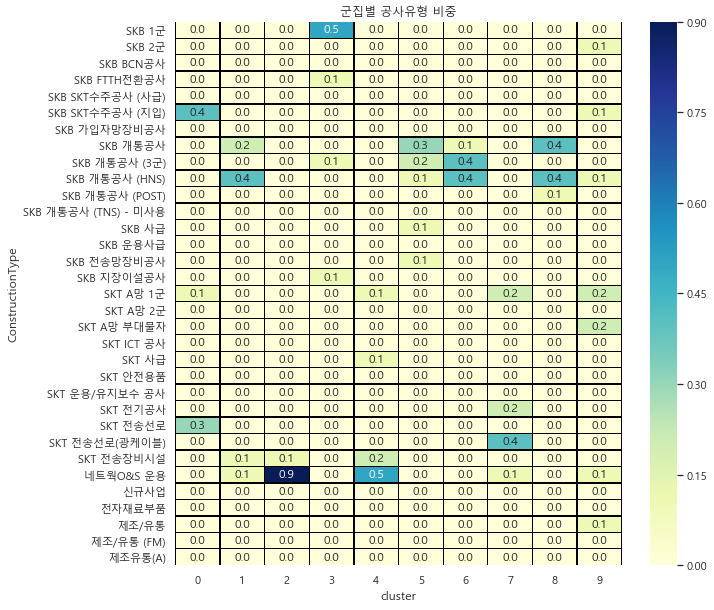

In [16]:
features['num'] =1
pv_features = features.pivot_table(index='ConstructionType', columns = 'cluster', values='num', aggfunc=np.sum).fillna(0)

for ii in pv_features.columns:
    pv_features[ii] = round(pv_features[ii]/pv_features.sum(axis =0)[ii],1)
    
plt.figure(figsize=(10,10))
plt.title("군집별 공사유형 비중")
sns.heatmap(pv_features,cmap='YlGnBu', annot=True, fmt="", linewidths=.3, linecolor='black')
plt.show()

In [38]:
# 시각화용 데이터 가공2 - TSNE
%time datapoint = TSNE(n_components=2, n_iter=5000).fit_transform(model.docvecs.vectors_docs)

clu_model = KMeans(n_clusters=1)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.merge(
        pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpID'], dtype='str'), 
        X_data2[['BpID','BpType','BpClass','ConstructionType','Region']].drop_duplicates(keep='first'), 
        on='BpID'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)

Wall time: 3min 35s


C:\Users\kim85\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


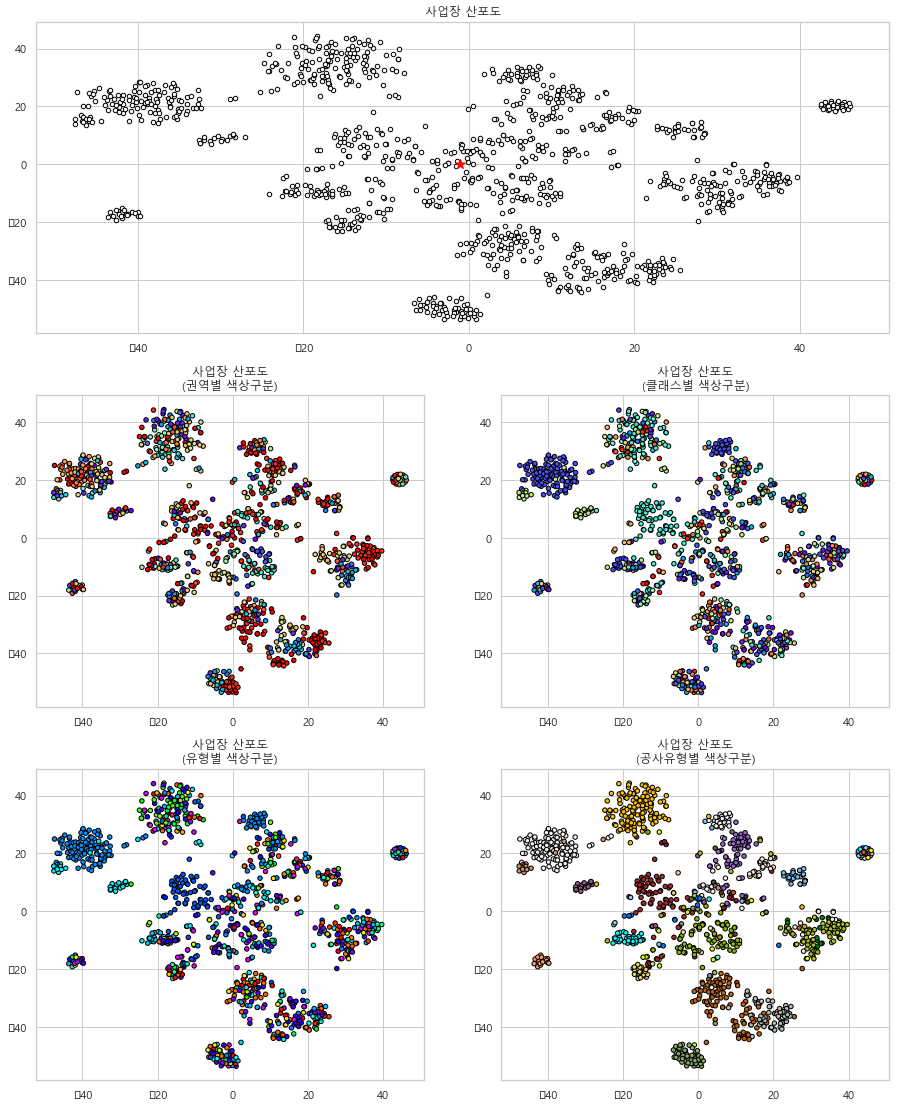

In [39]:
# 시각화2
plt.figure(figsize=(15,15))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.2, right=0.99)

plt.subplot(3,1,1)
plt.title('사업장 산포도')#.set_size(30)
plt.scatter(features.x, features.y, c='white', s = 20, edgecolors='black')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=100, c='red')

plt.subplot(3,2,3)
le = LabelEncoder()
lecolor = le.fit_transform(features.Region)
plt.title('사업장 산포도\n(권역별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('rainbow_r'))

plt.subplot(3,2,4)
le = LabelEncoder()
lecolor = le.fit_transform(features.BpClass)
plt.title('사업장 산포도\n(클래스별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('rainbow'))

plt.subplot(3,2,5)
le = LabelEncoder()
lecolor = le.fit_transform(features.BpType)
plt.title('사업장 산포도\n(유형별 색상구분)')
plt.scatter(features.x, features.y, c=lecolor, s = 20, edgecolors='black', cmap = plt.get_cmap('gist_rainbow'))

plt.subplot(3,2,6)
le = LabelEncoder()
lecolor = le.fit_transform(features.ConstructionType)
plt.title('사업장 산포도\n(공사유형별 색상구분)')
plt.scatter(features.x, features.y, c=[colorlist[lecolor[ii]] for ii in range(len(lecolor))], s = 20, edgecolors='black')

plt.show()

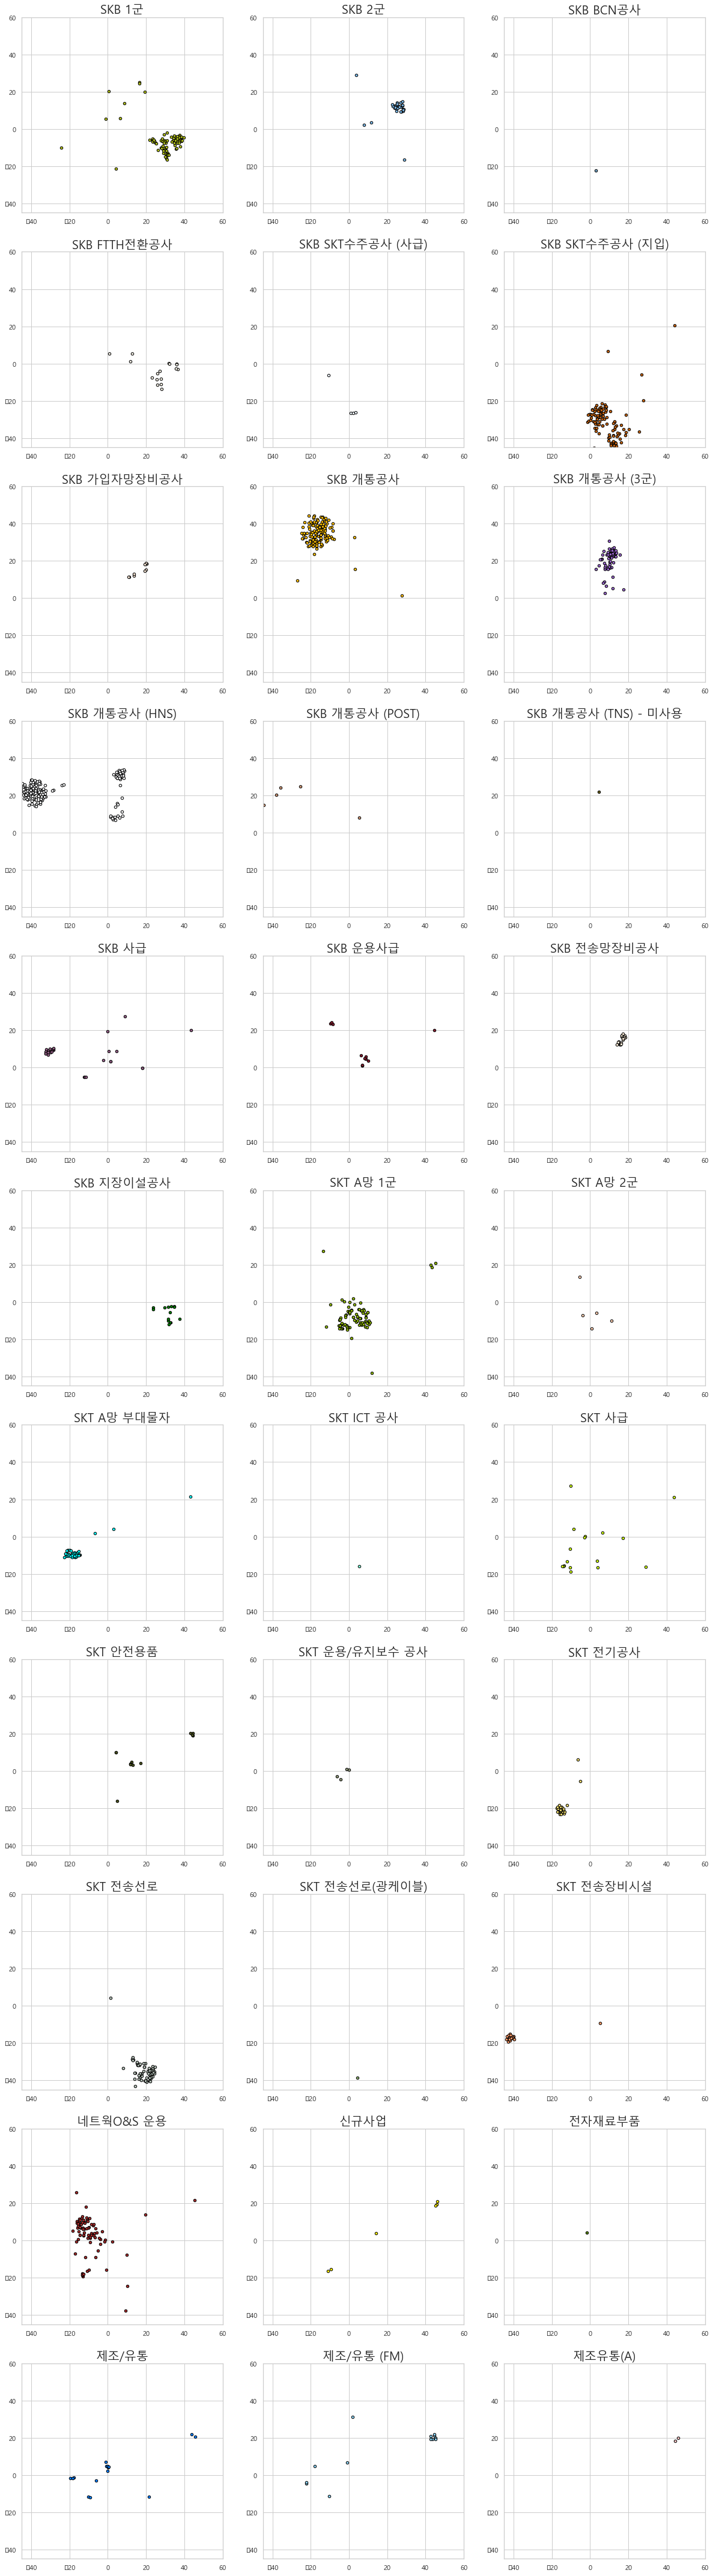

In [40]:
# 공사유형별 개별 시각화2
plt.figure(figsize=(20,60))
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.2, right=0.99)
le = LabelEncoder()
lecolor = le.fit_transform(features.ConstructionType)
ConstructionTypes = le.classes_

for ii in range(len(ConstructionTypes)):
    plt.subplot(11,3,ii+1)
    plt.title("%s" %(ConstructionTypes[ii])).set_size(20)
    tmp_feature = features[features.ConstructionType == ConstructionTypes[ii]]
    plt.scatter(tmp_feature.x, tmp_feature.y, c=colorlist[ii],s = 20, edgecolors='black')
    plt.xlim(-45,60)
    plt.ylim(-45,60)
plt.show()

C:\Users\kim85\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


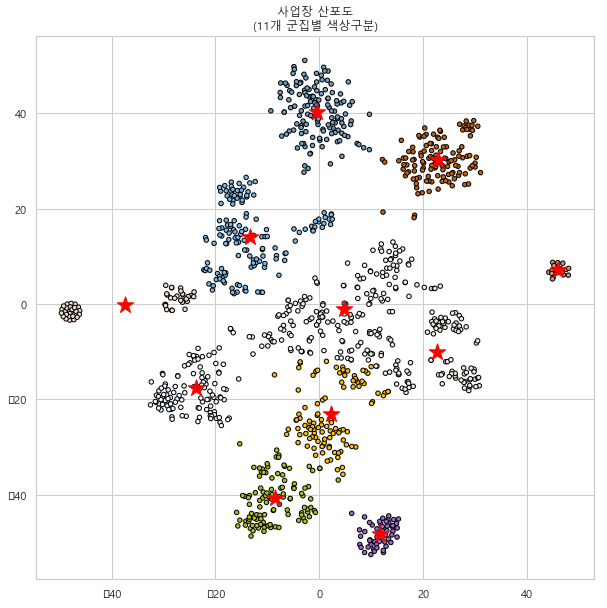

In [20]:
clu_model = KMeans(n_clusters=11)
clu_model.fit(datapoint)
labels=clu_model.labels_
centroids = clu_model.cluster_centers_

r_names = model.docvecs.offset2doctag
eudist = euclidean_distances(datapoint)
eudist2 = {r_names[ii] + "↔"+  r_names[jj]:eudist[ii,jj] for ii,jj in combinations(np.arange(datapoint.shape[0]),2)}

features = pd.merge(
    pd.merge(
        pd.DataFrame(model.docvecs.offset2doctag, columns = ['BpID'], dtype='str'), 
        X_data2[['BpID','BpType','BpClass','ConstructionType','Region']].drop_duplicates(keep='first'), 
        on='BpID'), 
    pd.DataFrame(datapoint, columns = ['x','y'], dtype='float64'), left_index=True, right_index=True)
features['cluster'] = labels

plt.figure(figsize=(10,10))
plt.title('사업장 산포도\n(11개 군집별 색상구분)')
plt.scatter(features.x, features.y, c=[colorlist[features.cluster[ii]] for ii in range(len(features.cluster))], s = 20, edgecolors='black')
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=300, c='red')
plt.show()

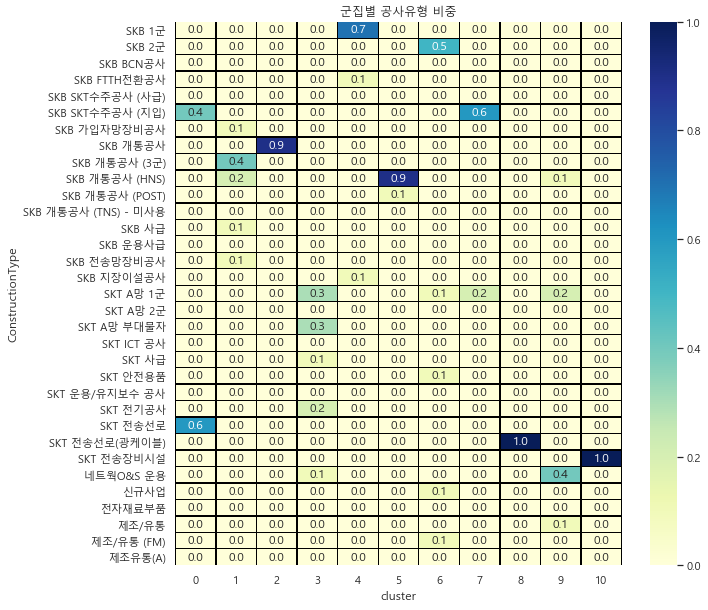

In [21]:
features['num'] =1
pv_features = features.pivot_table(index='ConstructionType', columns = 'cluster', values='num', aggfunc=np.sum).fillna(0)

for ii in pv_features.columns:
    pv_features[ii] = round(pv_features[ii]/pv_features.sum(axis =0)[ii],1)
    
plt.figure(figsize=(10,10))
plt.title("군집별 공사유형 비중")
sns.heatmap(pv_features,cmap='YlGnBu', annot=True, fmt="", linewidths=.3, linecolor='black')
plt.show()